# CSE3CI Lab 10: Recurrent Neural Network


### RNN and LSTM

Now that you are familier with building Neural Networks, and this week,lets learn RNNs. 
In the lecture, we have learned that time series prediction is a difficult modeling problem, that has to handle the complexity of a sequence dependency, among the input variables. As you have seen in the lecture, a powerful type of neural network designed to handle sequence dependence are called RNNs. 
In this lab we first build a simple RNN network, and then build a more complex RNN -- Long Short-Term Memory Networks (LSTM) network (Refer to Lecture), which have proven to be an improved version of RNN.
In this lab you will discover how to develop both a simple RNN and LSTM model in Python (using Keras).
After completing this tutorial you will be able to implement and develop RNN networks for your own time series prediction tasks, or other more general sequence problems. 

### Airline Passengers Prediction

In this lab we look at the international airline passengers prediction problem, where we are given a year and a month, and are required to predict the number of international airline passengers in units of 1,000. 
Dataset is downloaded from : 
https://www.kaggle.com/chirag19/air-passengers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# loading the airline dataset
dataframe = pd.read_csv("AirPassengers.csv")
#take a look at the original dataset
dataframe.head(10)
dataframe[:10]

Using TensorFlow backend.


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [2]:
#Parse strings to datetime type
dataframe['Month'] = pd.to_datetime(dataframe['Month'], infer_datetime_format=True) #convert from string to datetime
#Set datatime as dataframe index
dataframe = dataframe.set_index(['Month'])
dataframe.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


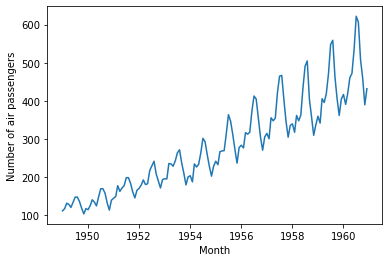

In [3]:
## plot graph
plt.plot(dataframe)
plt.xlabel('Month')
plt.ylabel('Number of air passengers')
plt.show()

### Normalize the data
An important note to keep in mind about RNN and LSTM is that they are sensitive to the scale of the input data. We normalize the data by rescaling it to the range of 0-to-1, we use MinMaxScaler preprocessing to normalize the dataset.

In [4]:
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# spliting the data into train and test sets
train, test = train_test_split(dataset, test_size=0.33, shuffle=False)

### Create the dataset
Now we need a function that transfers our dataset into a:
dataset and the "time", where "time indicates the number of previous time-steps to use as input variables to predict the next time period (in this case the default is 1). 
This will create a dataset where train_X is the number of passengers at a given time (t) and teai_Y is the number of passengers at the next time (t+1). 


In [6]:
# convert the array of values into a matrix (the format requireb by LSTM)
def create_dataset(dataset, time=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time-1):
        a = dataset[i:(i+time), 0]
        data_X.append(a)
        data_Y.append(dataset[i + time, 0])
    return np.array(data_X), np.array(data_Y)

### Reshaping the data

In [7]:
# RNN networks require data to be presented in the bellow specific array structure:
# [samples, time steps, features]. That is why we are reshaping our data. 
time = 1
train_X, train_Y = create_dataset(train, time)
test_X, test_Y = create_dataset(test, time)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

### Build the RNN

In [8]:
# creating the simple RNN network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(time, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


### Train and evaluate the mode

In [9]:
# training and predictions
model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=0)
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# inverting predictions (since we did maxmin transformation on dataset, we need to transform it back)
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

In [10]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_Y[0], train_predict[:,0]))
print('Train_performance: %.2f RMSE' % (train_score))
test_performance = math.sqrt(mean_squared_error(test_Y[0], test_predict[:,0]))
print('Test_performance: %.2f RMSE' % (test_performance))

# calculate r_squared
train_r_squared = r2_score(train_Y[0], train_predict[:,0])
print('Train_performance: %.2f R2' % (train_r_squared))
test_r_squared = r2_score(test_Y[0], test_predict[:,0])
print('Test_performance: %.2f R2' % (test_r_squared))

Train_performance: 22.73 RMSE
Test_performance: 49.04 RMSE
Train_performance: 0.90 R2
Test_performance: 0.60 R2


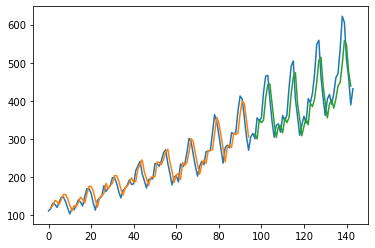

In [11]:
#plotting train and test predictions 
train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time:len(train_predict)+time, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time*2)+1:len(dataset)-1, :] = test_predict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

try with time period of 6 months

Train_performance: 21.90 RMSE
Test_performance: 57.79 RMSE
Train_performance: 0.90 R2
Test_performance: 0.46 R2


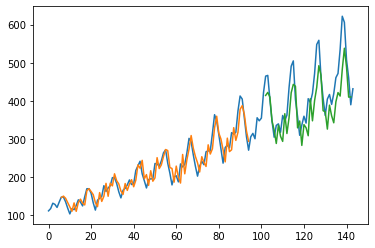

In [15]:
# RNN networks require data to be presented in the bellow specific array structure:
# [samples, time steps, features]. That is why we are reshaping our data. 
time = 6
train_X, train_Y = create_dataset(train, time)
test_X, test_Y = create_dataset(test, time)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

# creating the RNN network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(time, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# training and predictions
model.fit(train_X, train_Y, epochs=100, batch_size=4, verbose=0)
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# inverting predictions (since we did maxmin transformation on dataset, we need to transform it back)
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_Y[0], train_predict[:,0]))
print('Train_performance: %.2f RMSE' % (train_score))
test_performance = math.sqrt(mean_squared_error(test_Y[0], test_predict[:,0]))
print('Test_performance: %.2f RMSE' % (test_performance))

# calculate r_squared
train_r_squared = r2_score(train_Y[0], train_predict[:,0])
print('Train_performance: %.2f R2' % (train_r_squared))
test_r_squared = r2_score(test_Y[0], test_predict[:,0])
print('Test_performance: %.2f R2' % (test_r_squared))

#plotting train and test predictions 
train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time:len(train_predict)+time, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time*2)+1:len(dataset)-1, :] = test_predict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

### Build a LSTM model

Train_performance: 22.73 RMSE
Test_performance: 49.61 RMSE
Train_performance: 0.90 R2
Test_performance: 0.59 R2


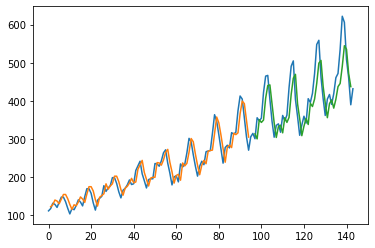

In [13]:
# LSTM networks require data to be presented in the bellow specific array structure:
# [samples, time steps, features]. That is why we are reshaping our data. 
time = 1
train_X, train_Y = create_dataset(train, time)
test_X, test_Y = create_dataset(test, time)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

# creating the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(time, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# training and predictions
model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=0)
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# inverting predictions (since we did maxmin transformation on dataset, we need to transform it back)
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_Y[0], train_predict[:,0]))
print('Train_performance: %.2f RMSE' % (train_score))
test_performance = math.sqrt(mean_squared_error(test_Y[0], test_predict[:,0]))
print('Test_performance: %.2f RMSE' % (test_performance))

# calculate r_squared
train_r_squared = r2_score(train_Y[0], train_predict[:,0])
print('Train_performance: %.2f R2' % (train_r_squared))
test_r_squared = r2_score(test_Y[0], test_predict[:,0])
print('Test_performance: %.2f R2' % (test_r_squared))

#plotting train and test predictions 
train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time:len(train_predict)+time, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time*2)+1:len(dataset)-1, :] = test_predict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

try with time period of 6 months

Train_performance: 22.61 RMSE
Test_performance: 60.24 RMSE
Train_performance: 0.89 R2
Test_performance: 0.41 R2


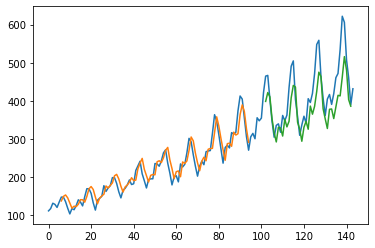

In [14]:
# LSTM networks require data to be presented in the bellow specific array structure:
# [samples, time steps, features]. That is why we are reshaping our data. 
time = 6
train_X, train_Y = create_dataset(train, time)
test_X, test_Y = create_dataset(test, time)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

# creating the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(time, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# training and predictions
model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=0)
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# inverting predictions (since we did maxmin transformation on dataset, we need to transform it back)
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_Y[0], train_predict[:,0]))
print('Train_performance: %.2f RMSE' % (train_score))
test_performance = math.sqrt(mean_squared_error(test_Y[0], test_predict[:,0]))
print('Test_performance: %.2f RMSE' % (test_performance))

# calculate r_squared
train_r_squared = r2_score(train_Y[0], train_predict[:,0])
print('Train_performance: %.2f R2' % (train_r_squared))
test_r_squared = r2_score(test_Y[0], test_predict[:,0])
print('Test_performance: %.2f R2' % (test_r_squared))

#plotting train and test predictions 
train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time:len(train_predict)+time, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time*2)+1:len(dataset)-1, :] = test_predict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()